**UTS Analisis Data Tidak Terstruktur**

Siti Nur Salamah (2206048833)

Program Studi Matematika, Fakultas Matematika dan Ilmu Pengetahuan Alam, Universitas Indonesia

# 1. Import Library

In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312 (from 1)
Receiving objects: 100% (460/460), 4.83 MiB | 7.13 MiB/s, done.
Resolving deltas: 100% (229/229), done.


In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt_tab')
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Load Dataset

In [ ]:
!gdown 1nyg4SXYnAJ_JOcWwC5hP5y_uBqS4ODoa
!gdown 1WeFxtwxno5VXTIf2QhrmezDWKMNSrdVD
!gdown 12FDjRiSkpLHjDWo2v3c8rh_e11EnYu6l

Downloading...
From: https://drive.google.com/uc?id=1nyg4SXYnAJ_JOcWwC5hP5y_uBqS4ODoa
To: /content/flip_cat_balance.tsv
100% 245k/245k [00:00<00:00, 4.75MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WeFxtwxno5VXTIf2QhrmezDWKMNSrdVD
To: /content/kamus_alay.csv
100% 49.9k/49.9k [00:00<00:00, 71.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=12FDjRiSkpLHjDWo2v3c8rh_e11EnYu6l
To: /content/stopword.txt
100% 788/788 [00:00<00:00, 3.14MB/s]


In [ ]:
df_path = 'flip_cat_balance.tsv'
stopword_path = '/content/stopword.txt'
kamus_alay_path = 'kamus_alay.csv'

df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

print(df.head())
print(f'Shape: {df.shape}')
print(f'Label unik: {df["category"].unique()}')

                                         review_text  category
0  Itu gimna yah aku tranfer sesama BRI, Kok lama...  negative
1  Aku coba transaksi trus nominal kurang jd aku ...  negative
2                              Bank Mega Gak ada hmm  negative
3  Aplikasi busuk jangan di download rugi nomor s...  negative
4  Kenapa saya masuk akun tidak bisa ? Password s...  negative
Shape: (2820, 2)
Label unik: ['negative' 'neutral' 'positive']


In [ ]:
df

,review_text,category
0,"Itu gimna yah aku tranfer sesama BRI, Kok lama...",negative
1,Aku coba transaksi trus nominal kurang jd aku ...,negative
2,Bank Mega Gak ada hmm,negative
3,Aplikasi busuk jangan di download rugi nomor s...,negative
4,Kenapa saya masuk akun tidak bisa ? Password s...,negative
...,...,...
2815,bagus. aplikasi nya mudah digunakan cm kekuran...,positive
2816,Untuk pertama kali pakai lumayan menghemat bia...,positive
2817,"Hehe, lumayan ngirit 6500😁😁💰",positive
2818,Bagus banget,positive


In [ ]:
# Ambil 3 contoh kalimat per kategori
for label in df['category'].unique():
    print(f"\nContoh kalimat untuk sentimen {label}:")
    sample_texts = df[df['category'] == label]['review_text'].sample(3, random_state=42)
    for text in sample_texts:
        print(f"- {text}")


Contoh kalimat untuk sentimen negative:
- Saya mengalami kendala dalam konfirmasi email...sampai sekarang blm bisa saya pake aplikasi nya...konfirmasi emailnya lamaaaaaaaa banget ga ada keterangan apapun pas saya tekan konfirmasi email,malah biru layar saya....
- Saya kesulitan verifikasi Akun, masukkan npmor KTP hanya muter2 ga bisa sukses
- Lama banget ngecek nyaaa,ga bisa ditunggu ini mah,malah lama banget woi

Contoh kalimat untuk sentimen neutral:
- Tolong dtambh lagi batas minim kirimnya.biar kami tidak kecewa.kami yg tidak bisa verifikasi akun
- Cara top up nya gimana
- Masih dicoba

Contoh kalimat untuk sentimen positive:
- Giood
- Smoga lbh cpt prosesnya
- Mudah kirim ke berbagai bank dan proses aman dan cepat ,yg pastinya gratis biaya admin,flip muach... Bdw mau tanya kira kira brp batas maksimal untuk transaksi transfer,tq


## Proporsi Variabel Target

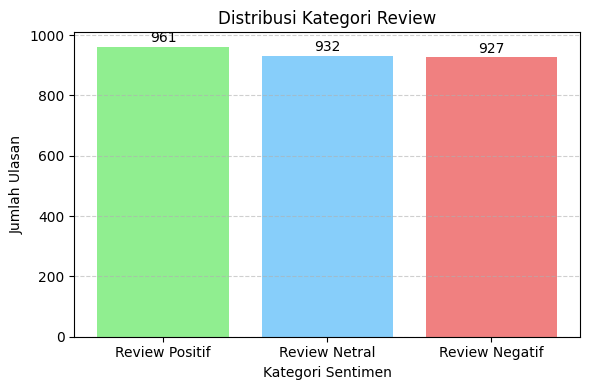

In [ ]:
# Data
sizes = df['category'].value_counts().reindex(['positive', 'neutral', 'negative'])
sizes = sizes.fillna(0)
labels = ['Review Positif', 'Review Netral', 'Review Negatif']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, sizes, color=colors)

# Tambahkan nilai di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha='center', va='bottom')

plt.title('Distribusi Kategori Review')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

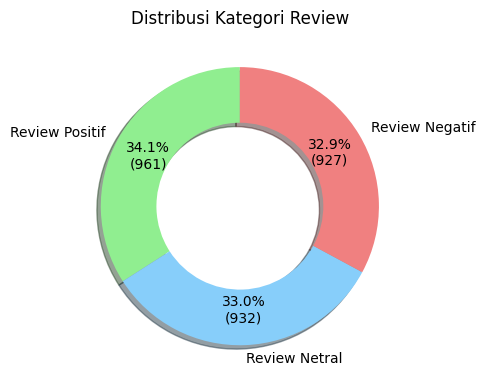

In [ ]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# Function
def donut(sizes, ax, angle=90, labels=None, colors=None, explode=None, shadow=None):
    ax.pie(sizes, colors=colors, labels=labels,
           autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(sizes) / 100),
           startangle=angle, pctdistance=0.75,
           explode=explode, wedgeprops=dict(width=0.4), shadow=shadow)
    ax.set(aspect="equal")

# Plot
sizes = df['category'].value_counts().reindex(['positive', 'neutral', 'negative'])
sizes = sizes.fillna(0)
labels = ['Review Positif', 'Review Netral', 'Review Negatif']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0, 0, 0)

donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Distribusi Kategori Review')
plt.tight_layout()
plt.show()

Perhatikan bahwa proporsi antar kelas seimbang sehingga ini bagus untuk training model karena tidak terlalu bias kelas

# Pre-processing
---
Preprocessing dilakukan untuk mengubah dataset yang tidak terstruktur menjadi terstruktur sehingga mempermudah data untuk diproses dengan melakukan beberapa tahapan yaitu case folding, data cleaning, tokenisasi, dan normalisasi kata tidak baku.

## 1. Case Folding & Data Cleaning

In [ ]:
# Daftar karakter untuk deteksi karakter berulang
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# Hapus karakter yang berulang minimal 3 kali
def repeatcharClean(text):
    for i in range(len(character)):
        charac_long = 5
        while charac_long > 2:
            char = character[i] * charac_long
            text = text.replace(char, character[i])
            charac_long -= 1
    return text

# Cleaning function
def clean_review(text):
    text = text.lower()  # Case folding
    text = re.sub(r'\n', ' ', text)  # Replace newline
    text = emoji.demojize(text)  # Convert emoji to text
    text = re.sub(':[A-Za-z_-]+:', ' ', text)  # Remove emoji text
    text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)  # Remove emoticon
    text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)  # Remove URLs
    text = re.sub(r"@[^\s]+[\s]?", ' ', text)  # Remove @username
    text = re.sub(r'#(\S+)', r'\1', text)  # Remove hashtags
    text = re.sub('[^a-zA-Z,.?!]+', ' ', text)  # Remove numbers and symbols
    text = repeatcharClean(text)  # Clean repeated characters
    text = re.sub('[ ]+', ' ', text)  # Normalize whitespace
    return text.strip()

# Pipeline preprocessing
def preprocess_v1(df):
    df_pp = df.copy()
    df_pp.review_text = df_pp.review_text.astype(str).map(clean_review)
    df_pp.review_text.replace('', np.nan, inplace=True)
    df_pp.review_text.replace(' ', np.nan, inplace=True)
    df_pp.dropna(subset=['review_text'], inplace=True)
    return df_pp

# Jalankan
df_v1 = preprocess_v1(df)

<ipython-input-11-253d35ae724d>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pp.review_text.replace('', np.nan, inplace=True)
<ipython-input-11-253d35ae724d>:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

## Tokenisasi & Normalisasi Kata Tidak Baku

In [ ]:
# Load kamus alay langsung
kamus_alay = pd.read_csv('kamus_alay.csv', names=['slang', 'formal'])

# Buat dictionary normalisasi
normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

# Normalisasi kata
def normalize_review(text):
  # Tokenisasi kata
  list_text = word_tokenize(text)
  # Ganti kata alay ke baku
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  # Gabung lagi jadi string
  text = " ".join(list_text)
  return text

# Pipeline tahap 2
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.review_text = df_pp.review_text.map(normalize_review)

  # Hapus baris kosong
  df_pp.review_text.replace('', np.nan, inplace=True)
  df_pp.review_text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['review_text'], inplace=True)
  return df_pp

# Eksekusi
df_v2 = preprocess_v2(df_v1)

<ipython-input-12-1acee1c87a91>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalize_word_dict:
<ipython-input-12-1acee1c87a91>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalize_word_dict[row[0]] = row[1]
<ipython-input-12-1acee1c87a91>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [ ]:
df_v2

,review_text,category
0,"itu bagaimana ya aku transfer sesama bri , kok...",negative
1,aku coba transaksi terus nominal kurang jadi a...,negative
2,bank mega enggak ada hmm,negative
3,aplikasi busuk jangan di download rugi nomor s...,negative
4,kenapa saya masuk akun tidak bisa ? password s...,negative
...,...,...
2815,bagus . aplikasi nya mudah digunakan cuma keku...,positive
2816,untuk pertama kali pakai lumayan menghemat bia...,positive
2817,"hehe , lumayan ngirit",positive
2818,bagus banget,positive


# EDA

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

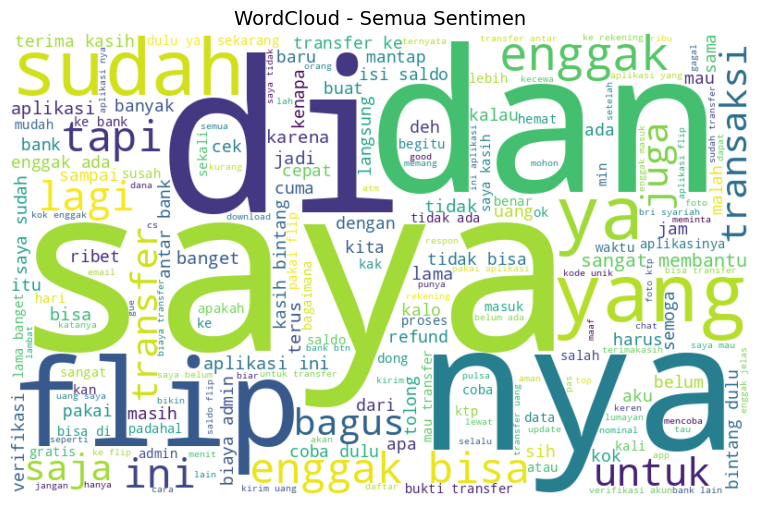

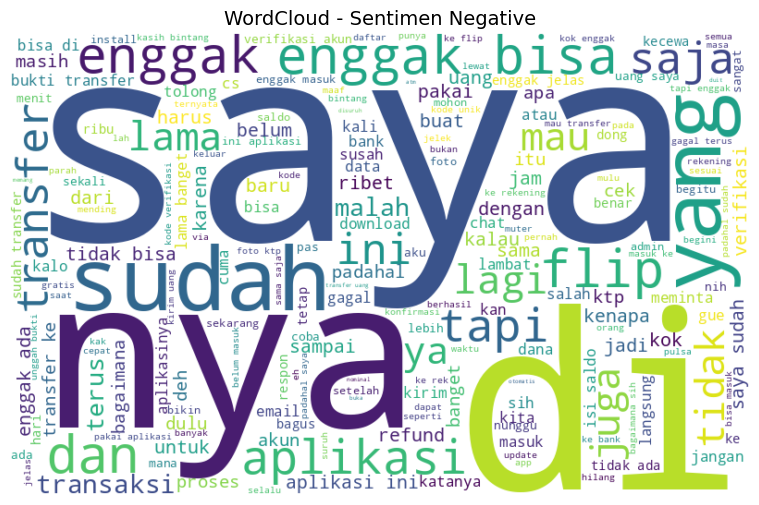

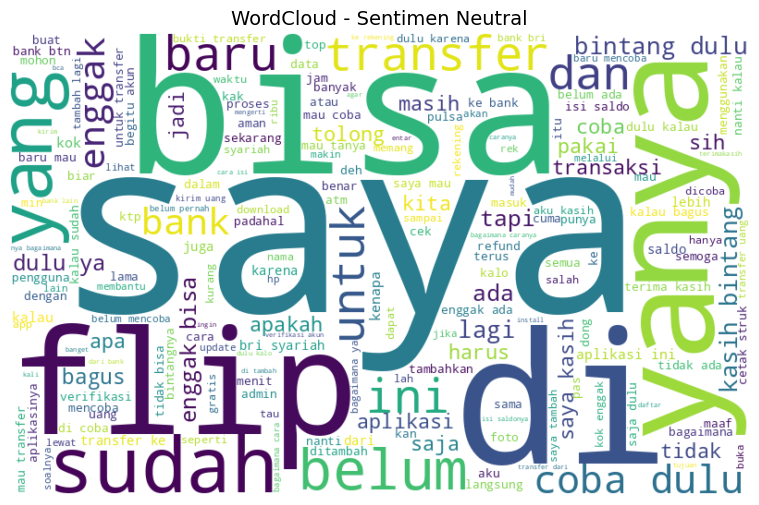

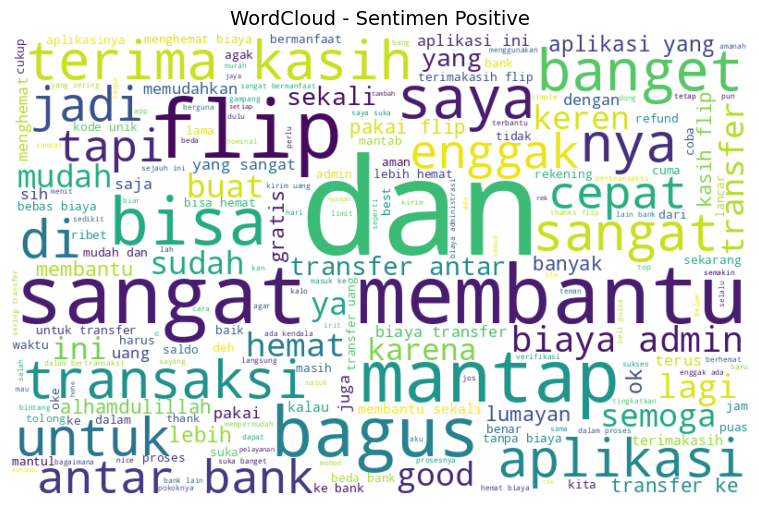

In [ ]:
# Fungsi bantu untuk menampilkan WordCloud
def show_wordcloud(text, title=None):
    wordcloud = WordCloud(width=800, height=500, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

# WordCloud semua data
all_text = " ".join(df_v2['review_text'])
show_wordcloud(all_text, title="WordCloud - Semua Sentimen")

# WordCloud per kategori sentimen
for label in df_v2['category'].unique():
    text = " ".join(df_v2[df_v2['category'] == label]['review_text'])
    show_wordcloud(text, title=f"WordCloud - Sentimen {label.capitalize()}")

# Splitting

In [ ]:
# train val split
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.category, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.category, random_state=1)

print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (1963, 2)
Val shape: (564, 2)
Test shape: (278, 2)


In [ ]:
def print_distribution(name, dataset):
    print(f'\nDistribusi kategori pada {name}:')
    print(dataset['category'].value_counts())
    print(dataset['category'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}'))

# Tampilkan distribusi
print_distribution('Train Set', train_set)
print_distribution('Validation Set', val_set)
print_distribution('Test Set', test_set)


Distribusi kategori pada Train Set:
category
positive    668
neutral     648
negative    647
Name: count, dtype: int64
category
positive    34.03%
neutral     33.01%
negative    32.96%
Name: proportion, dtype: object

Distribusi kategori pada Validation Set:
category
positive    192
neutral     186
negative    186
Name: count, dtype: int64
category
positive    34.04%
neutral     32.98%
negative    32.98%
Name: proportion, dtype: object

Distribusi kategori pada Test Set:
category
positive    94
negative    92
neutral     92
Name: count, dtype: int64
category
positive    33.81%
negative    33.09%
neutral     33.09%
Name: proportion, dtype: object


In [ ]:
# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

# Modeling

## COMMON FUNCTION

In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

# Set random seed
set_seed(27)

## [MODEL INDOBERT P1]

In [ ]:
# Load Tokenizer and Config P1
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model P1
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

# Dataset paths
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

# Load dataset
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

# Training
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    history['train_acc'].append(metrics['ACC'])

    # Validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss = 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        valid_loss = loss.item()
        total_loss += valid_loss

        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    history['val_acc'].append(metrics['ACC'])

# Save validation predictions
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.to_csv('val result.csv', index=False)

# Test predictions
model.eval()
torch.set_grad_enabled(False)
pred = []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.to_csv('test result.csv', index=False)

val_real = val_df.category
test_real = test_df.category
val_pred = val_df.pred
test_pred = test_df.pred

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


(Epoch 1) TRAIN LOSS:0.8432 LR:0.00000300: 100%|██████████| 62/62 [00:24<00:00,  2.50it/s]


(Epoch 1) TRAIN LOSS:0.8432 ACC:0.64 F1:0.64 REC:0.64 PRE:0.64 LR:0.00000300


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.6155 ACC:0.79 F1:0.79 REC:0.79 PRE:0.79: 100%|██████████| 18/18 [00:02<00:00,  6.12it/s]


(Epoch 1) VALID LOSS:0.6155 ACC:0.79 F1:0.79 REC:0.79 PRE:0.79


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 2) TRAIN LOSS:0.5030 LR:0.00000300: 100%|██████████| 62/62 [00:24<00:00,  2.57it/s]


(Epoch 2) TRAIN LOSS:0.5030 ACC:0.82 F1:0.82 REC:0.82 PRE:0.82 LR:0.00000300


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.4548 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83: 100%|██████████| 18/18 [00:02<00:00,  6.13it/s]


(Epoch 2) VALID LOSS:0.4548 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 3) TRAIN LOSS:0.3759 LR:0.00000300: 100%|██████████| 62/62 [00:24<00:00,  2.51it/s]


(Epoch 3) TRAIN LOSS:0.3759 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87 LR:0.00000300


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.4531 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83: 100%|██████████| 18/18 [00:02<00:00,  6.00it/s]


(Epoch 3) VALID LOSS:0.4531 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 4) TRAIN LOSS:0.3201 LR:0.00000300: 100%|██████████| 62/62 [00:24<00:00,  2.53it/s]


(Epoch 4) TRAIN LOSS:0.3201 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89 LR:0.00000300


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.4311 ACC:0.84 F1:0.84 REC:0.84 PRE:0.84: 100%|██████████| 18/18 [00:03<00:00,  5.50it/s]


(Epoch 4) VALID LOSS:0.4311 ACC:0.84 F1:0.84 REC:0.84 PRE:0.84


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 5) TRAIN LOSS:0.2779 LR:0.00000300: 100%|██████████| 62/62 [00:25<00:00,  2.47it/s]


(Epoch 5) TRAIN LOSS:0.2779 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.00000300


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.4347 ACC:0.85 F1:0.85 REC:0.85 PRE:0.85: 100%|██████████| 18/18 [00:03<00:00,  5.27it/s]


(Epoch 5) VALID LOSS:0.4347 ACC:0.85 F1:0.85 REC:0.85 PRE:0.85


  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


### Evaluasi INDOBERT P1

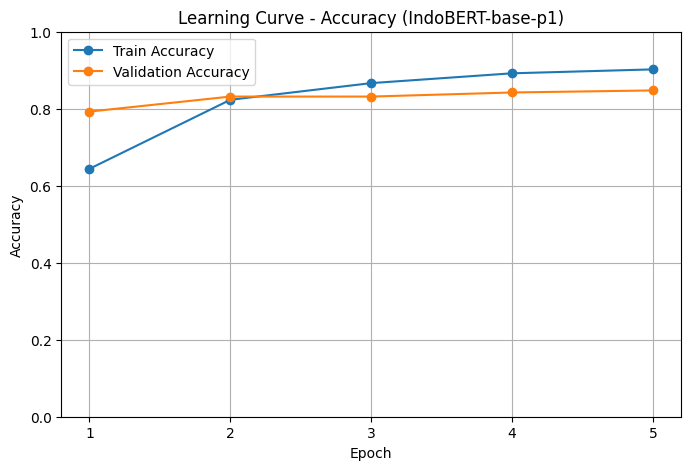


=== CLASSIFICATION REPORT VALIDASI: INDO-BERT P1 ===


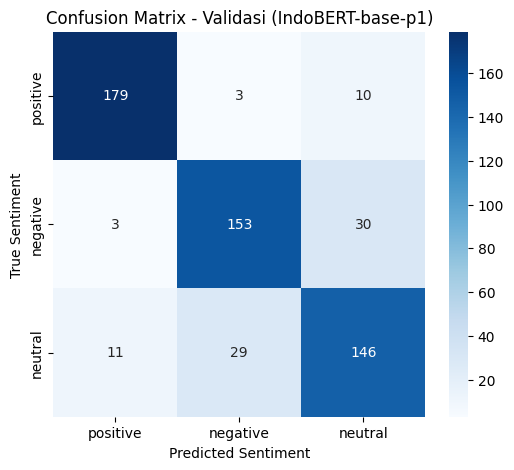

              precision    recall  f1-score   support

    positive       0.93      0.93      0.93       192
    negative       0.83      0.82      0.82       186
     neutral       0.78      0.78      0.78       186

    accuracy                           0.85       564
   macro avg       0.85      0.85      0.85       564
weighted avg       0.85      0.85      0.85       564


=== CLASSIFICATION REPORT TEST: INDO-BERT P1 ===


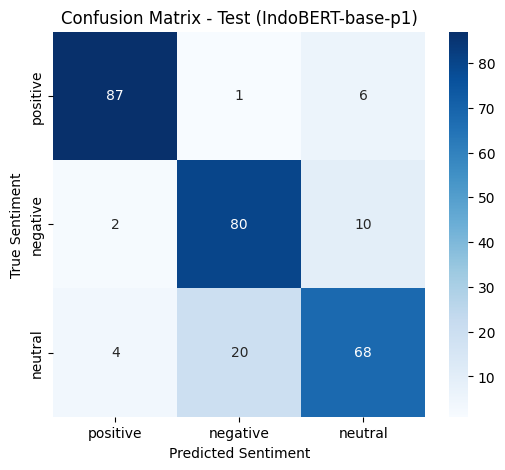

              precision    recall  f1-score   support

    positive       0.94      0.93      0.93        94
    negative       0.79      0.87      0.83        92
     neutral       0.81      0.74      0.77        92

    accuracy                           0.85       278
   macro avg       0.85      0.84      0.84       278
weighted avg       0.85      0.85      0.84       278



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Pastikan urutan labelnya sesuai distribusi dataset
labels = ['positive', 'negative', 'neutral']

# ======== PLOT AKURASI ========
epochs = range(1, len(history['train_acc']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Learning Curve - Accuracy (IndoBERT-base-p1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()

# ======== PLOT LOSS (jika tersedia) ========
if 'train_loss' in history and 'val_loss' in history:
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Learning Curve - Loss (IndoBERT-base-p1)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()
    plt.show()

# ======== CONFUSION MATRIX & REPORT VALIDASI ========
print("\n=== CLASSIFICATION REPORT VALIDASI: INDO-BERT P1 ===")
cm_val = confusion_matrix(val_real, val_pred, labels=labels)
df_cm_val = pd.DataFrame(cm_val, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm_val, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Validasi (IndoBERT-base-p1)")
plt.ylabel("True Sentiment")
plt.xlabel("Predicted Sentiment")
plt.show()

print(classification_report(val_real, val_pred, labels=labels, target_names=labels))

# ======== CONFUSION MATRIX & REPORT TEST ========
print("\n=== CLASSIFICATION REPORT TEST: INDO-BERT P1 ===")
cm_test = confusion_matrix(test_real, test_pred, labels=labels)
df_cm_test = pd.DataFrame(cm_test, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test (IndoBERT-base-p1)")
plt.ylabel("True Sentiment")
plt.xlabel("Predicted Sentiment")
plt.show()

print(classification_report(test_real, test_pred, labels=labels, target_names=labels))

## [MODEL INDOBERT P2]

In [ ]:
# Load Tokenizer and Config P2
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p2')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model P2
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', config=config)

# Dataset paths
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

# Load dataset
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

# Training
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) [P2] TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) [P2] TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    history['train_acc'].append(metrics['ACC'])

    # Validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss = 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        valid_loss = loss.item()
        total_loss += valid_loss

        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS [P2]:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) [P2] VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    history['val_acc'].append(metrics['ACC'])

# Save validation predictions
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.to_csv('val_result_p2.csv', index=False)

# Test predictions
model.eval()
torch.set_grad_enabled(False)
pred = []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.to_csv('test_result_p2.csv', index=False)

val_real = val_df.category
val_pred = val_df.pred
test_real = test_df.category
test_pred = test_df.pred

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/62 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

(Epoch 1) [P2] TRAIN LOSS:0.8895 LR:0.00000300: 100%|██████████| 62/62 [00:24<00:00,  2.49it/s]


(Epoch 1) [P2] TRAIN LOSS:0.8895 ACC:0.61 F1:0.61 REC:0.61 PRE:0.61 LR:0.00000300


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS [P2]:0.6747 ACC:0.78 F1:0.78 REC:0.78 PRE:0.78: 100%|██████████| 18/18 [00:03<00:00,  5.14it/s]


(Epoch 1) [P2] VALID LOSS:0.6747 ACC:0.78 F1:0.78 REC:0.78 PRE:0.78


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 2) [P2] TRAIN LOSS:0.5143 LR:0.00000300: 100%|██████████| 62/62 [00:26<00:00,  2.35it/s]


(Epoch 2) [P2] TRAIN LOSS:0.5143 ACC:0.82 F1:0.82 REC:0.82 PRE:0.82 LR:0.00000300


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS [P2]:0.4713 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83: 100%|██████████| 18/18 [00:04<00:00,  4.48it/s]


(Epoch 2) [P2] VALID LOSS:0.4713 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 3) [P2] TRAIN LOSS:0.3789 LR:0.00000300: 100%|██████████| 62/62 [00:24<00:00,  2.50it/s]


(Epoch 3) [P2] TRAIN LOSS:0.3789 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87 LR:0.00000300


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS [P2]:0.4404 ACC:0.84 F1:0.84 REC:0.84 PRE:0.83: 100%|██████████| 18/18 [00:03<00:00,  5.61it/s]


(Epoch 3) [P2] VALID LOSS:0.4404 ACC:0.84 F1:0.84 REC:0.84 PRE:0.83


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 4) [P2] TRAIN LOSS:0.3216 LR:0.00000300: 100%|██████████| 62/62 [00:24<00:00,  2.57it/s]


(Epoch 4) [P2] TRAIN LOSS:0.3216 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89 LR:0.00000300


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS [P2]:0.4437 ACC:0.84 F1:0.84 REC:0.84 PRE:0.84: 100%|██████████| 18/18 [00:03<00:00,  5.66it/s]


(Epoch 4) [P2] VALID LOSS:0.4437 ACC:0.84 F1:0.84 REC:0.84 PRE:0.84


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 5) [P2] TRAIN LOSS:0.2789 LR:0.00000300: 100%|██████████| 62/62 [00:25<00:00,  2.47it/s]


(Epoch 5) [P2] TRAIN LOSS:0.2789 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.00000300


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS [P2]:0.4546 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83: 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]


(Epoch 5) [P2] VALID LOSS:0.4546 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83


  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 9/9 [00:01<00:00,  4.78it/s]


### Evaluasi INDOBERT P2

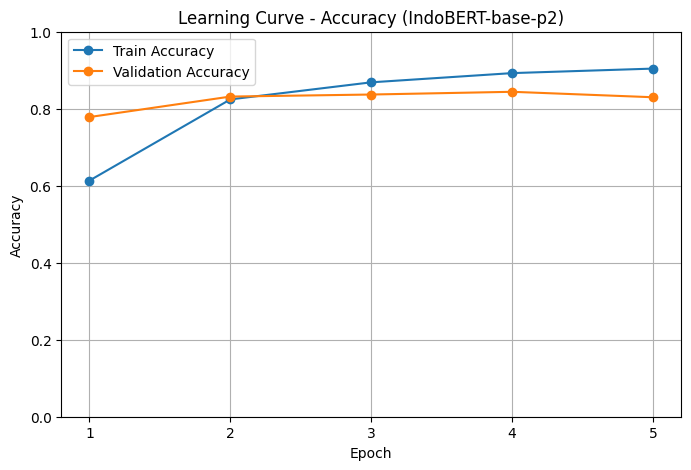


=== CLASSIFICATION REPORT VALIDASI: INDO-BERT P2 ===


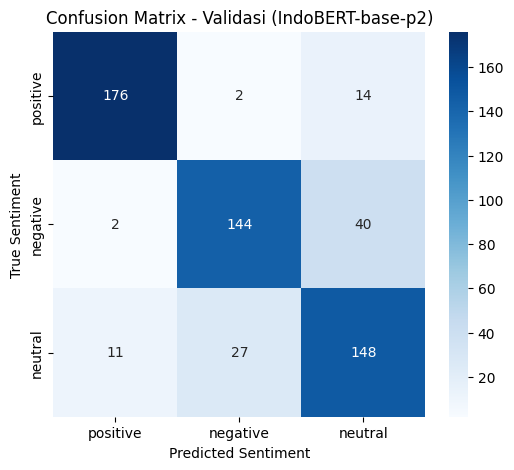

              precision    recall  f1-score   support

    positive       0.93      0.92      0.92       192
    negative       0.83      0.77      0.80       186
     neutral       0.73      0.80      0.76       186

    accuracy                           0.83       564
   macro avg       0.83      0.83      0.83       564
weighted avg       0.83      0.83      0.83       564


=== CLASSIFICATION REPORT TEST: INDO-BERT P2 ===


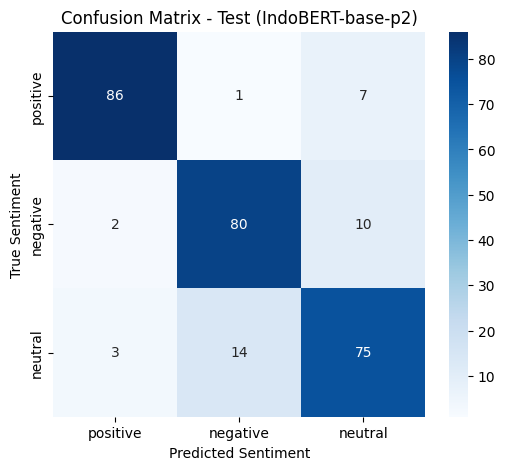

              precision    recall  f1-score   support

    positive       0.95      0.91      0.93        94
    negative       0.84      0.87      0.86        92
     neutral       0.82      0.82      0.82        92

    accuracy                           0.87       278
   macro avg       0.87      0.87      0.87       278
weighted avg       0.87      0.87      0.87       278



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Label sesuai urutan distribusi data
labels = ['positive', 'negative', 'neutral']

# ======== PLOT AKURASI ========
epochs = range(1, len(history['train_acc']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Learning Curve - Accuracy (IndoBERT-base-p2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()

# ======== PLOT LOSS (jika tersedia) ========
if 'train_loss' in history and 'val_loss' in history:
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Learning Curve - Loss (IndoBERT-base-p2)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()
    plt.show()

# ======== CONFUSION MATRIX & REPORT VALIDASI ========
print("\n=== CLASSIFICATION REPORT VALIDASI: INDO-BERT P2 ===")
cm_val = confusion_matrix(val_real, val_pred, labels=labels)
df_cm_val = pd.DataFrame(cm_val, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm_val, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Validasi (IndoBERT-base-p2)")
plt.ylabel("True Sentiment")
plt.xlabel("Predicted Sentiment")
plt.show()

print(classification_report(val_real, val_pred, labels=labels, target_names=labels))

# ======== CONFUSION MATRIX & REPORT TEST ========
print("\n=== CLASSIFICATION REPORT TEST: INDO-BERT P2 ===")
cm_test = confusion_matrix(test_real, test_pred, labels=labels)
df_cm_test = pd.DataFrame(cm_test, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test (IndoBERT-base-p2)")
plt.ylabel("True Sentiment")
plt.xlabel("Predicted Sentiment")
plt.show()

print(classification_report(test_real, test_pred, labels=labels, target_names=labels))